### Let's apply our Vision model
you need to run this with version 0.9.13 of Carla simulator

In [1]:
#all imports
import os
import carla #the sim library itself
import time # to set a delay after each photo
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
import math
import sys
import random
sys.path.append('/opt/carla-simulator/PythonAPI/carla') # tweak to where you put carla
from keras.models import load_model
from agents.navigation.global_route_planner import GlobalRoutePlanner
from matplotlib import pyplot as plt 

# disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

2025-01-20 10:07:30.266210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-20 10:07:30.749613: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 10:07:33.712335: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/winter/.pyenv/versions/3.7.17/envs/carla-0.9.13-py3.7/lib/python3.7/site-packages

In [2]:
client = carla.Client('10.8.179.139', 2000)
# start a car
world = client.get_world()

#clean up
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

In [3]:
# Define basic settings
PREFERRED_SPEED = 30
SPEED_THRESHOLD = 2 # defines when we get close to desired speed so we drop the speed

# Max steering angle
MAX_STEER_DEGREES = 40
# This is max actual angle with Mini under steering input=1.0
STEERING_CONVERSION = 75

CAMERA_POS_Z = 1.3 
CAMERA_POS_X = 1.4 

# resize images before running thgem through the model
# this is the same as when yo train the model
HEIGHT = 180
WIDTH = 320

In [4]:
# utility function for camera listening 
def camera_callback(image,data_dict):
    data_dict['image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))[:, :, :3]

# utility function for camera listening 
def sem_callback(image,data_dict):
    ########## IMPORTANT CHANGE for Semantic camera ##############
    image.convert(carla.ColorConverter.CityScapesPalette)
    data_dict['sem_image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))[:, :, :3]

# maintain speed function
def maintain_speed(s):
    ''' 
    this is a very simple function to maintan desired speed
    s arg is actual current speed
    '''
    if s >= PREFERRED_SPEED:
        return 0
    elif s < PREFERRED_SPEED - SPEED_THRESHOLD:
        return 0.9 # think of it as % of "full gas"
    else:
        return 0.4 # tweak this if the car is way over or under preferred speed 


# function to get angle between the car and target waypoint
def get_angle(car,wp):
    '''
    this function returns degrees between the car's direction 
    and direction to a selected waypoint
    '''
    vehicle_pos = car.get_transform()
    car_x = vehicle_pos.location.x
    car_y = vehicle_pos.location.y
    wp_x = wp.transform.location.x
    wp_y = wp.transform.location.y
    
    # vector to waypoint
    x = (wp_x - car_x)/((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
    y = (wp_y - car_y)/((wp_y - car_y)**2 + (wp_x - car_x)**2)**0.5
    
    #car vector
    car_vector = vehicle_pos.get_forward_vector()
    degrees = math.degrees(np.arctan2(y, x) - np.arctan2(car_vector.y, car_vector.x))
    # extra checks on predicted angle when values close to 360 degrees are returned
    if degrees<-180:
        degrees = degrees + 360
    elif degrees > 180:
        degrees = degrees - 360
    return degrees

def get_proper_angle(car,wp_idx,rte):
    '''
    This function uses simple fuction above to get angle but for current
    waypoint and a few more next waypoints to ensure we have not skipped
    next waypoint so we avoid the car trying to turn back
    '''
    # create a list of angles to next 5 waypoints starting with current
    next_angle_list = []
    for i in range(10):
        if wp_idx + i*3 <len(rte)-1:
            next_angle_list.append(get_angle(car,rte[wp_idx + i*3][0]))
    idx = 0
    while idx<len(next_angle_list)-2 and abs(next_angle_list[idx])>40:
        idx +=1
    return wp_idx+idx*3,next_angle_list[idx]  

def get_distant_angle(car,wp_idx,rte, delta):
    '''
    This function modifies the fuction above to get angle to a waypoint
    at a distance so we could use it for training image generation
    
    We will display the angle for now in the 'telemetry' view so
    we could play with how far forward we need to pick the waypoint
    '''
    if wp_idx + delta < len(rte)-1:
        i = wp_idx + delta
    else:
        i = len(rte)-1
    # check for intersection within the "look forward"
    # so we do not give turn results when just following the road
    intersection_detected = False
    for x in range(i-wp_idx):
        if rte[wp_idx+x][0].is_junction:
             intersection_detected = True
    angle = get_angle(car,rte[i][0])
    if not intersection_detected:
        result = 0
    elif angle <-10:
        result = -1
    elif angle>10:
        result =1
    else:
        result = 0    
    return result

def draw_route(wp, route,seconds=3.0):
    #draw the next few points route in sim window - Note it does not
    # get into the camera of the car
    if len(route)-wp <25: # route within 25 points from end is red
        draw_colour = carla.Color(r=255, g=0, b=0)
    else:
        draw_colour = carla.Color(r=0, g=0, b=255)
    for i in range(10):
        if wp+i<len(route)-2:
            world.debug.draw_string(route[wp+i][0].transform.location, '^', draw_shadow=False,
                color=draw_colour, life_time=seconds,
                persistent_lines=True)
    return None


def select_random_route(position,locs):
    '''
    retruns a random route for the car/veh
    out of the list of possible locations locs
    where distance is longer than 100 waypoints
    '''    
    point_a = position.location #we start at where the car is or last waypoint
    sampling_resolution = 1
    grp = GlobalRoutePlanner(world.get_map(), sampling_resolution)
    # now let' pick the longest possible route
    min_distance = 100
    result_route = None
    route_list = []
    for loc in locs: # we start trying all spawn points 
                                #but we just exclude first at zero index
        cur_route = grp.trace_route(point_a, loc.location)
        if len(cur_route) > min_distance:
            route_list.append(cur_route)
    result_route = random.choice(route_list)
    return result_route

def exit_clean():
    #clean up
    cv2.destroyAllWindows()
    for sensor in world.get_actors().filter('*sensor*'):
        sensor.destroy()
    for actor in world.get_actors().filter('*vehicle*'):
        actor.destroy()
    return None

def predict_angle(sem_im,direction):
    # tweaks for prediction
    img = np.float32(sem_im)
    img = img /255
    img = np.expand_dims(img, axis=0)
    #print('input shape: ',img.shape)
    angle = model([img,np.reshape(direction, (1, 1))],training=False)
    return  angle.numpy()[0][0]


# spawn the car
world = client.get_world()
spawn_points = world.get_map().get_spawn_points()
#look for a blueprint of Tesla m3 car
vehicle_bp = world.get_blueprint_library().filter('*model3*')

# load CNN model
MODEL_NAME = 'GPS_Visual_Model_over'
model = load_model(MODEL_NAME,compile=False)
model.compile()
quit = False

2025-01-20 10:07:49.868875: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-01-20 10:07:49.869158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (HASS-DESKTOP6): /proc/driver/nvidia/version does not exist
2025-01-20 10:07:49.871020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# main loop
while True:
    start_point = random.choice(spawn_points)
    vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)
    time.sleep(2)
    #setting RGB Camera - this follow the approach explained in a Carla video
    camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
    camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.14 on Windows
    camera_bp.set_attribute('image_size_y', '360')
    camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
    #this creates the camera in the sim
    camera = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)
    image_w = camera_bp.get_attribute('image_size_x').as_int()
    image_h = camera_bp.get_attribute('image_size_y').as_int()

    camera_bp = world.get_blueprint_library().find('sensor.camera.semantic_segmentation')
    camera_bp.set_attribute('fov', '90')
    camera_bp.set_attribute('image_size_x', '640') 
    camera_bp.set_attribute('image_size_y', '360')
    camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
    camera_sem = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)
    image_w = 640
    image_h = 360

    camera_data = {'sem_image': np.zeros((image_h,image_w,4)),
                   'image': np.zeros((image_h,image_w,4))}

    # this actually opens a live stream from the camera
    camera.listen(lambda image: camera_callback(image,camera_data))
    camera_sem.listen(lambda image: sem_callback(image,camera_data))
    cv2.namedWindow('RGB Camera',cv2.WINDOW_AUTOSIZE)
    cv2.imshow('RGB Camera',camera_data['image'])
    # getting a random route for the car
    route = select_random_route(start_point,spawn_points)
    curr_wp = 5 #we will be tracking waypoints in the route and switch to next one when we get close to current one
    predicted_angle = 0
    PREFERRED_SPEED = 40 # setting speed at start of new route
    
    spectator = world.get_spectator()
    spectator_pos = carla.Transform(start_point.location + carla.Location(x=-20,y=10,z=10),
                                carla.Rotation(yaw = start_point.rotation.yaw -155))
    spectator.set_transform(spectator_pos)

    while curr_wp<len(route)-1:
        # Carla Tick
        world.tick()
        draw_route(curr_wp, route,1)
        if cv2.waitKey(1) == ord('q'):
            quit = True
            exit_clean()
            break
        image = camera_data['image']
        sem_image = camera_data['sem_image']
        
        sem_image = cv2.resize(sem_image, (WIDTH,HEIGHT))


        # Spectator Update
        spectator_transform = vehicle.get_transform()
        spectator_transform.location += carla.Location(x=0, y=0, z=15)
        spectator_transform.rotation.yaw += -15  # left
        spectator_transform.rotation.pitch = -60 # downward
        spectator.set_transform(spectator_transform)
        
        if curr_wp >=len(route)-10: # within 10 points of end, the route is done
            PREFERRED_SPEED = 0 # seeting speed to 0 after completing one route
            exit_clean()
            break
        while curr_wp<len(route)-2 and vehicle.get_transform().location.distance(route[curr_wp][0].transform.location)<5:
            curr_wp +=1 #move to next wp if we are too close
        curr_wp, predicted_angle = get_proper_angle(vehicle,curr_wp,route)
        distant_angle = get_distant_angle(vehicle,curr_wp,route,30)
        
        v = vehicle.get_velocity()
        speed = round(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2),0)

        estimated_throttle = maintain_speed(speed)
        # use the model to predict steering - predictions are expected to be in -1 to +1
        steer_input = predict_angle(sem_image,distant_angle)
        
        vehicle.apply_control(carla.VehicleControl(throttle=float(estimated_throttle), steer=float(steer_input)))
        cv2.imshow('RGB Camera',image)
    if quit:
        break

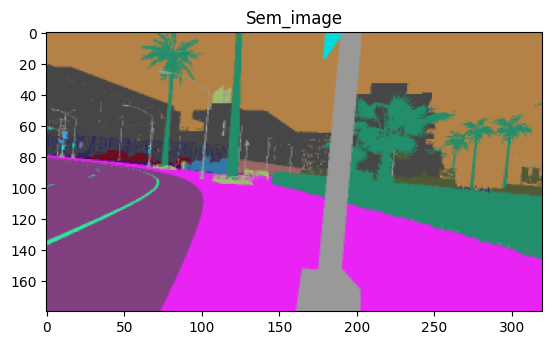

In [19]:
plt.imshow(sem_image)
plt.title('Sem_image')
plt.show()

In [8]:
cv2.destroyAllWindows()
camera.stop()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()

In [9]:
input_layers = model.input

# Print the shape of each input layer
for layer in input_layers:
    print(layer.shape)

(None, 180, 320, 3)
(None, 1)


In [10]:
steer_input

-0.08238703

In [11]:
print(start_point.location)

Location(x=-109.929558, y=-23.428406, z=0.599995)
